In [6]:
import numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
import os
os.chdir(r"C:\Users\stude\Documents\StephCurryProject")

df = pd.read_csv("data/processed/curry_vs_league_by_season.csv")
df["year_start"] = df["SEASON"].str[:4].astype(int)
df["age"] = df["year_start"] - 1988 + 21 - (2009 - df["year_start"])  # quick proxy
use = df.dropna(subset=["GAP_TS_PCT"]).copy()

X = use[["age"]].values; y = use["GAP_TS_PCT"].values

def cv_rmse(model, X, y):
    return (-cross_val_score(model, X, y, cv=KFold(5, shuffle=True, random_state=42),
                             scoring="neg_root_mean_squared_error").mean())

# Linear baseline
lin = LinearRegression().fit(X, y)

# Poly(2)
poly = PolynomialFeatures(2, include_bias=False)
Xp = poly.fit_transform(X)
ridge = Ridge(alpha=1.0).fit(Xp, y)

print("CV RMSE (Linear):", cv_rmse(LinearRegression(), X, y))
print("CV RMSE (Ridge+Poly2):", cv_rmse(Ridge(alpha=1.0), Xp, y))

CV RMSE (Linear): 0.040048817234913596
CV RMSE (Ridge+Poly2): 0.0354689205945377


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
import json

df = pd.read_csv("data/processed/curry_vs_league_by_season.csv")

# Build an age column (Curry born 1988, rookie season 2009-10 at age ~21)
df["year_start"] = df["SEASON"].str.slice(0,4).astype(int)
df["age"] = df["year_start"] - 1988 + 21 - (2009 - df["year_start"])

use = df.dropna(subset=["GAP_TS_PCT"]).copy()
X = use[["age"]].values
y = use["GAP_TS_PCT"].values

def cv_rmse(model, X, y):
    return (-cross_val_score(
        model, X, y,
        cv=KFold(5, shuffle=True, random_state=42),
        scoring="neg_root_mean_squared_error"
    ).mean())

# Linear
lin = LinearRegression()
rmse_lin = cv_rmse(lin, X, y)

# Polynomial degree 2
poly = PolynomialFeatures(2, include_bias=False)
Xp = poly.fit_transform(X)
ridge = Ridge(alpha=1.0)   # Ridge is safer with small data
rmse_poly = cv_rmse(ridge, Xp, y)

print("Linear CV RMSE:", rmse_lin)
print("Poly(2)+Ridge CV RMSE:", rmse_poly)


Linear CV RMSE: 0.040048817234913596
Poly(2)+Ridge CV RMSE: 0.0354689205945377


In [7]:
if rmse_lin <= rmse_poly:
    model_type = "linear"
    lin.fit(X, y)
    model = lin
    ages_future = np.arange(int(use["age"].max())+1,
                            int(use["age"].max())+7).reshape(-1,1)
    pred_gap = model.predict(ages_future)
else:
    model_type = "poly2"
    ridge.fit(Xp, y)
    model = ridge
    ages_future = np.arange(int(use["age"].max())+1,
                            int(use["age"].max())+7).reshape(-1,1)
    pred_gap = model.predict(poly.transform(ages_future))

crossover_age = next((int(a) for a,g in zip(ages_future.flatten(), pred_gap) if g < 0), None)

print("Best model:", model_type)
print("Projected crossover age:", crossover_age)


Best model: poly2
Projected crossover age: 78


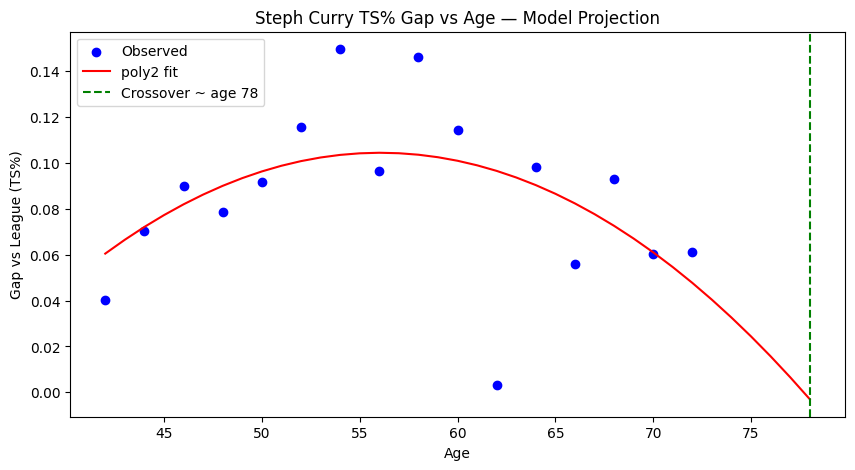

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(use["age"], y, label="Observed", color="blue")

age_line = np.arange(use["age"].min(), ages_future.max()+1).reshape(-1,1)
if model_type == "linear":
    y_line = model.predict(age_line)
else:
    y_line = model.predict(poly.transform(age_line))

plt.plot(age_line, y_line, color="red", label=f"{model_type} fit")
if crossover_age:
    plt.axvline(crossover_age, linestyle="--", color="green",
                label=f"Crossover ~ age {crossover_age}")

plt.title("Steph Curry TS% Gap vs Age — Model Projection")
plt.xlabel("Age")
plt.ylabel("Gap vs League (TS%)")
plt.legend()
plt.show()
